In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.regularizers import l2

In [2]:
dataset_dir = '/kaggle/input/leukemia/Original'
class_names = ['Benign', 'Pre', 'Pro', 'Early'] 

images = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(224, 224))  # Resize to match input size of VGG/ResNet
        img = img_to_array(img)
        img = preprocess_input(img)
        images.append(img)
        labels.append(class_name)

images = np.array(images)
labels = np.array(labels)

In [3]:
label_encoder = LabelEncoder() 
labels = label_encoder.fit_transform(labels)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=None, stratify=labels)

In [5]:
train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=128)
test_generator = test_datagen.flow(X_test, y_test, batch_size=128)

## Model Training

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
model.compile(optimizer=Adam(learning_rate=1e-6),  
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_generator, 
                    epochs=50,  
                    validation_data=test_generator,
                    callbacks=[early_stopping])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734151778.819721     104 service.cc:145] XLA service 0x7f2638005060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734151778.819787     104 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-12-14 04:49:55.357419: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,1024,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,2048,7,7]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackward

21/21 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.2895 - loss: 2.8020 - val_accuracy: 0.2883 - val_loss: 1.8354
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 557ms/step - accuracy: 0.4074 - loss: 1.9768 - val_accuracy: 0.3666 - val_loss: 1.5537
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 557ms/step - accuracy: 0.5152 - loss: 1.4750 - val_accuracy: 0.5215 - val_loss: 1.2481
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 555ms/step - accuracy: 0.6237 - loss: 1.0856 - val_accuracy: 0.6043 - val_loss: 1.0259
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 555ms/step - accuracy: 0.6780 - loss: 0.8855 - val_accuracy: 0.6748 - val_loss: 0.8486
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 556ms/step - accuracy: 0.7380 - loss: 0.7338 - val_accuracy: 0.7377 - val_loss: 0.6819
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 556ms/step - accuracy: 0.7816 - loss: 0.5535 - val_accuracy: 0.7761 - val_loss: 0.5466
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 556ms/step - accuracy: 0.8231 - loss: 0.5032 - val_accuracy: 0.8313 

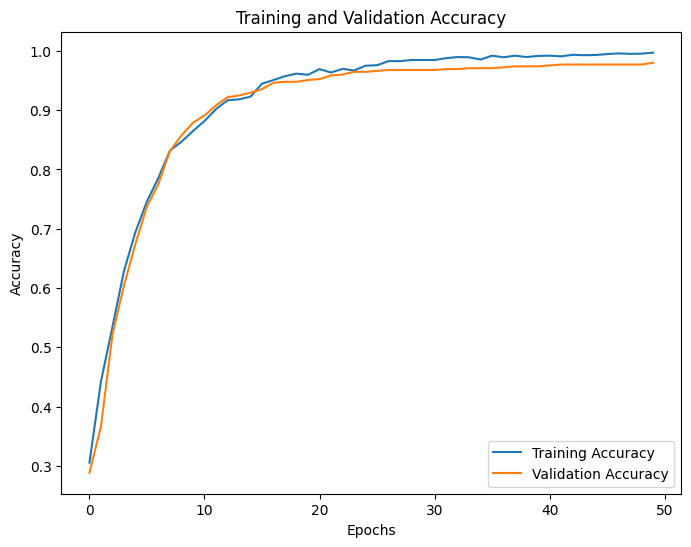

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

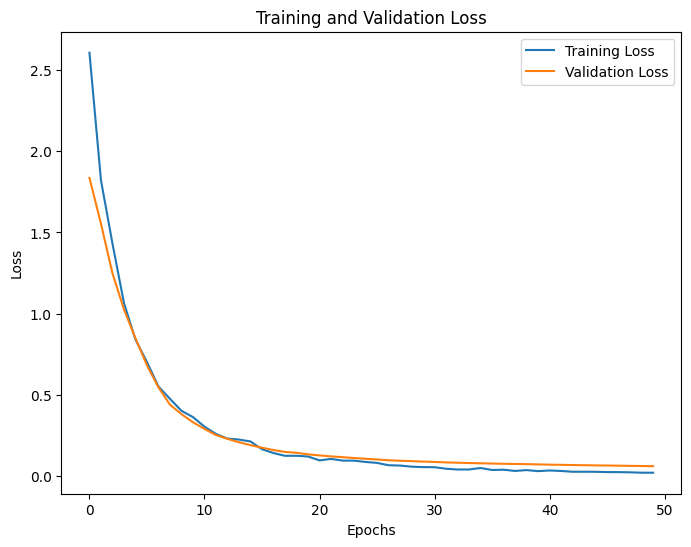

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [11]:
model.save('resnet50.h5')

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9700 - loss: 0.0788
Test Loss: 0.0619
Test Accuracy: 0.9801


## Evaluation Metrics

In [13]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('resnet50.h5')

In [14]:
from sklearn.metrics import classification_report

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=class_names))


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step
              precision    recall  f1-score   support

      Benign       0.94      0.94      0.94       101
         Pre       0.97      0.97      0.97       197
         Pro       1.00      0.99      0.99       193
       Early       0.99      1.00      1.00       161

    accuracy                           0.98       652
   macro avg       0.98      0.98      0.98       652
weighted avg       0.98      0.98      0.98       652



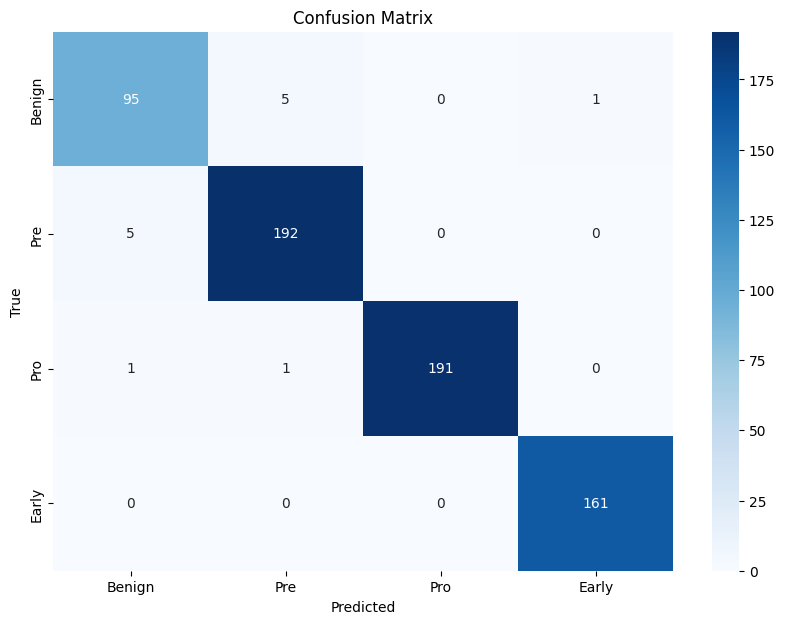

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()